# DeepEyeNet-Image Captioning with key word reinforced

### Parameter List:

**all_images**: all image path <br>
**all_jsons**: all json path

**names**: all file path<br>
       ex. eyenet_0819/cotton-wool-exudates/cotton-wool-exudates-4<br>
**keywords**: dictionary of all file path and its keywords <br>
           ex. 'eyenet_0819/cotton-wool-exudates/cotton-wool-exudates-4': \[cotton, wool, exudates\]<br>
**descriptions**: dictionary of all file path and its descriptions <br>
           ex. 'eyenet_0819/cotton-wool-exudates/cotton-wool-exudates-4': 'patient...'

**train_imgs**: all train image path<br>
**val_imgs**: all validation image path<br>
**test_imgs**: all test image path

**train_imgs_features**: all train image features<br>
**val_imgs_features**: all validation image features<br>
**test_imgs_features**: all test image features

**cap_toks**: dictionary of all file path and its description tokens<br>
**cap_ids**: dictionary of all file path and its description ids<br>
**unique_words_counts**: list of unique word (count=1)<br>
**word2id**: vocabulary {word: id}<br>
**id2word**: vocabulary {id: word}

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk

from keras.preprocessing import sequence, image
from keras.models import Sequential, Model, Input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Add, Lambda
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.models import load_model
import h5py

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# dictionary
word2id = {} # Count all word library
id2word = {} # Reverse word2id
vocab_size = 0 # All vocabulary size
maxlen = 0 # Longest caption length

# 1. Data Preparation

### Create caption list

In [3]:
def load_json(file):
    with open(file,'r') as f:
        return json.load(f)
def save_json(data, file):
    with open(file,'w') as f:
        json.dump(data, f)
def load_pickle(file):
    with open(file,'rb') as f:
        return pickle.load(f)
def save_pickle(data, file):
    with open(file,'wb') as f:
        pickle.dump(data, f)

In [4]:
# Store all images
def store_all(load=True):
    if load:
        all_images = load_pickle('./data/data_path/all_images.pkl')
        all_jsons = load_pickle('./data/data_path/all_jsons.pkl')
        return all_images, all_jsons
    
    all_images = glob.glob(root+'/*/*.jpg')
    all_jsons = glob.glob(root+'/*/*.json')
    save_pickle(all_images, './data/data_path/all_images.pkl')
    save_pickle(all_jsons, './data/data_path/all_jsons.pkl')
    return all_images, all_jsons

# Store subfolder images
def store_sub(subfolders, load=True):
    if load:
        sub_images = load_pickle('./data/data_path/sub_images.pkl')
        sub_jsons = load_pickle('./data/data_path/sub_jsons.pkl')
        return sub_images, sub_jsons
    
    sub_images = []
    sub_jsons = []
    _ = [sub_images.append(glob.glob(root+'/'+i+'/*/*.jpg')) for i in subfolders]
    _ = [sub_jsons.append(glob.glob(root+'/'+i+'/*/*.json')) for i in subfolders]
    sub_images = [img_path for l in sub_images for img_path in l]
    sub_jsons = [json_path for l in sub_jsons for json_path in l]
    save_pickle(sub_images, './data/data_path/sub_images.pkl')
    save_pickle(sub_jsons, './data/data_path/sub_jsons.pkl')
    return sub_images, sub_jsons

In [5]:
root = 'eyenet_0819'
subfolders = ['Age-related-macular-degeneration', 'CSC', 'DR', 'RVO']
load_all = False

# Rename the directory
for i in os.listdir(root):
    new_name = os.path.join(root,i.replace(' ','-'))
    os.rename(os.path.join(root,i),new_name)

In [6]:
if load_all:
    images, jsons = store_all(True)   
else:
    images, jsons = store_sub(subfolders, False)

print("Load Data Done!!")
print("Number of data:",len(images))

Load Data Done!!
Number of data: 1959


In [7]:
'''
Create data_path:

1. names: [img_path1 img_path2 img_path3 ...]
2. keywords: {img_path1: [keyword1-1,keyword1-2,...],
              img_path2: [keyword2-1,keyword2-2,...],
              ...}
3. descriptions: {img_path1: description1, img_path2: description2, ...}

'''

names = [img_path.split('.')[0] for img_path in images]
keywords = {}.fromkeys(names)
descriptions = {}.fromkeys(names)

for i in jsons:
    jj = load_json(i)
    header = i.split('.')[0]
    if header in names:
        keywords[header] = jj.get('condition-keywords','').split()
        descriptions[header] = jj.get('description','')

Name of image:  eyenet_0819/Age-related-macular-degeneration/macular-degeneration/macular-degeneration-17.jpg
Keywords:  macular degeneration
Descriptions:  52 year old caucasian emmotropic female with long term follow-up of presenile macular degeneration.


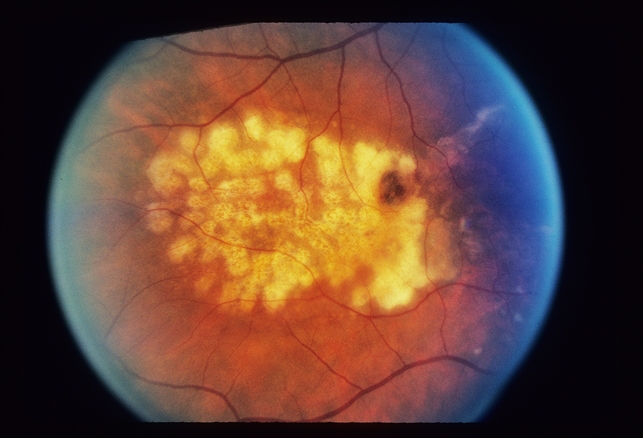

In [8]:
index = 1000
print("Name of image: ", names[index]+'.jpg')
print("Keywords: ", ' '.join(keywords[names[index]]))
print("Descriptions: ", descriptions[names[index]])
Image.open(names[index]+'.jpg')

### Random Split into train, validation, test data

In [9]:
np.random.seed(0)
indices = np.random.permutation(range(len(names)))
indices

array([ 279,  385,  983, ..., 1653,  559,  684])

In [13]:
split_point = [round(0.8*len(names)), round(0.9*len(names))]
train_imgs = [i for i in np.array(names)[indices[:split_point[0]]]]
val_imgs = [i for i in np.array(names)[indices[split_point[0]:split_point[1]]]]
test_imgs = [i for i in np.array(names)[indices[split_point[1]:]]]

In [14]:
print(len(train_imgs))
print(len(val_imgs))
print(len(test_imgs))

1567
196
196


macular atrophy.


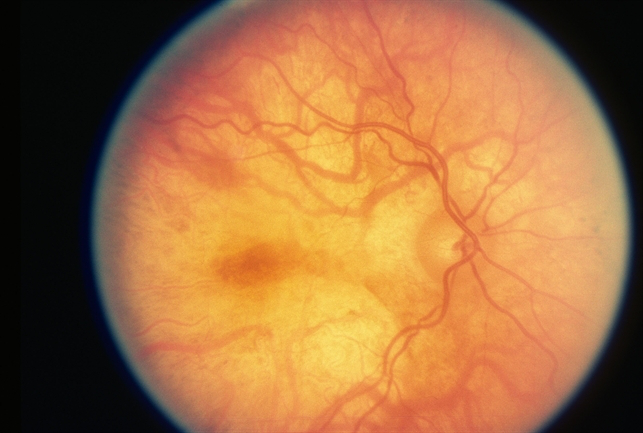

In [15]:
print(descriptions[train_imgs[120]])
Image.open(train_imgs[120]+'.jpg')

In [16]:
save_pickle(train_imgs, './data/data_path/train_imgs.pkl')
save_pickle(val_imgs, './data/data_path/val_imgs.pkl')
save_pickle(test_imgs, './data/data_path/test_imgs.pkl')

In [10]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# 2. Feature Extraction

### Image feature extracted from VGG16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


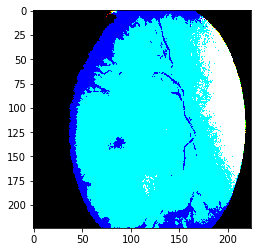

In [17]:
# Preprocess the images
def preprocess_img(img_path, dim):
    img = image.load_img(img_path, target_size=(dim, dim))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

test = preprocess_img(train_imgs[120]+'.jpg', 224)
plt.imshow(np.squeeze(test))

In [18]:
# Load VGG features
model = VGG16(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)

features = model_new.predict(test)
# print('Predicted:', decode_predictions(features, top=3)[0])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
features.shape

(1, 4096)

In [21]:
# Extract 
def extract_features(model, imgs):
    imgs_features = {}
    for img in tqdm(imgs):
        features = model.predict(preprocess_img(img+'.jpg', 224))
        imgs_features[img] = features.squeeze()
    return imgs_features

train_imgs_features = extract_features(model_new, train_imgs)
val_imgs_features = extract_features(model_new, val_imgs)
test_imgs_features = extract_features(model_new, test_imgs)

100%|██████████| 196/196 [00:07<00:00, 27.53it/s]


In [22]:
save_pickle(train_imgs_features, './data/img_features/train_imgs_features_vgg_sub.pkl')
save_pickle(val_imgs_features, './data/img_features/val_imgs_features_vgg_sub.pkl')
save_pickle(test_imgs_features, './data/img_features/test_imgs_features_vgg_sub.pkl')

In [11]:
train_imgs_features = load_pickle('./data/img_features/train_imgs_features_vgg_sub.pkl')
val_imgs_features = load_pickle('./data/img_features/val_imgs_features_vgg_sub.pkl')
test_imgs_features = load_pickle('./data/img_features/test_imgs_features_vgg_sub.pkl')

### Caption word encoding

In [12]:
# 1) Remove bad symbols and tokenization
REPLACE_BY_SPACE_RE = re.compile('[-(){}\[\]\|@;]')
BAD_SYMBOLS_RE = re.compile('[#+_]')
mxlen = 50

def text_prepare(text):
    """
        text: a string
        
        return: modified string tokens 
                [tok1, tok2 , ...] which is a single sentence from one character
    """
    tok = ["<START>"] # add START token to represent sentence start
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, '', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    tok += (text.split(" ")+["<EOS>"]) # add EOS token to represent sentence end
    if len(tok) > mxlen:
        tok = tok[:mxlen]
    
    return tok

In [13]:
# 2) Dictionary of all words from train corpus with their counts.
#    Dictionary of all words with its ids
def count_words(toks):
    """
    count:
    { tok1: count1, tok2: count2, ...}
    word2id:
    { tok1: id1, tok2: id2, ...}
    id2word:
    { id1: tok1, id2: tok2, ...}
    
    """
    count = {}
    
    # Special Tokens
    word2id["<START>"] = 0
    word2id["<EOS>"] = 1
    word2id["<UNK>"] = 2
    index = 3
    
    for tok in toks.values():
        for word in tok:
            # Count the words
            if not word in count:
                count[word] = 1
            else:
                count[word] += 1
            # Make dictionary
            if not word in word2id:
                word2id[word] = index
                index += 1
    return count

In [14]:
def text_tokenize(descriptions, word2id, id2word):
    
    """
     cap_toks: 
     [
        img_path1: [tok1, tok2, ...],
        img_path2: [tok1, tok2, ...],
        img_path3: [tok1, tok2, ...],
        img_path4: [tok1, tok2, ...],
        ...
     ]
     
     cap_ids: 
     [
        img_path1: [id1, id2, ...],
        img_path2: [id1, id2, ...],
        img_path3: [id1, id2, ...],
        img_path4: [id1, id2, ...],
        ...
     ]
     
     unique_words_counts: a list of words that appear only once.
     [tok1, tok2, tok3, ...]
     
    """
    cap_toks = {k: text_prepare(v) for k,v in descriptions.items()}

    # Count the words that appears only once.
    words_counts = count_words(cap_toks)
    unique_words_counts = [x[0] for x in sorted(words_counts.items(), key = lambda x: x[1], reverse=True) if x[1] == 1]
    
    # Arrange word2id and id2word
    word2id = {key: i for i, key in enumerate(word2id.keys())}
    id2word = {i:symbol for symbol, i in word2id.items()}
    
    cap_ids = defaultdict()
    for img_path, toks in cap_toks.items():
        cap_ids[img_path] = [word2id[tok] for tok in toks]
        
    
    return cap_toks, cap_ids, unique_words_counts, word2id, id2word

In [15]:
cap_toks, cap_ids, unique_words_counts, word2id, id2word = text_tokenize(descriptions, word2id, id2word)

In [16]:
print("Descriptions before tokenizing, encoding: \n", descriptions[names[index]])
print("\nDescriptions after tokenizing: \n", cap_toks[names[index]])
print("\nDescriptions after encoding: \n", cap_ids[names[index]])

Descriptions before tokenizing, encoding: 
 52 year old caucasian emmotropic female with long term follow-up of presenile macular degeneration.

Descriptions after tokenizing: 
 ['<START>', '52', 'year', 'old', 'caucasian', 'emmotropic', 'female', 'with', 'long', 'term', 'follow', 'up', 'of', 'presenile', 'macular', 'degeneration.', '<EOS>']

Descriptions after encoding: 
 [0, 15, 4, 5, 321, 322, 323, 38, 324, 325, 326, 327, 36, 328, 274, 329, 1]


In [17]:
len(word2id)

858

### Keyword Preprocessing

In [36]:
# Add keywords into vocabulary list
word2id_keys = word2id.copy()

keywords_list = list(set([word for v in keywords.values() for word in v]))
index = len(word2id)

for i in keywords_list:
    if i not in word2id_keys:
        word2id_keys[i] = index
        index += 1

keywords_ids = defaultdict()
for img_path, words in keywords.items():
    keywords_ids[img_path] = [word2id_keys[word] for word in words]

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
 
corpus = [" ".join(v) for k,v in cap_toks.items()]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
words = vectorizer.get_feature_names()
words2id_vec = {word: i for i,word in enumerate(words)}

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X).toarray()
tfidf

array([[0.        , 0.        , 0.        , ..., 0.13115948, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.13115948, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.13115948, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03818493, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03818493, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03818493, 0.        ,
        0.        ]])

In [25]:
tfidf[0,words2id_vec["white"]]

0.16804629597096243

### Add all parameters into results

In [31]:
results = {"name": names,
           "keywords": keywords,
           "descriptions": descriptions,
           "cap_toks": cap_toks,
           "cap_ids": cap_ids,
           "word2id": word2id,
           "id2word": id2word,
           "word2id_keys": word2id_keys,
           "keywords_ids": keywords_ids
          }
save_pickle(results, './data/data_path/results.pkl')

In [18]:
# Important features
results = load_pickle('./data/data_path/results.pkl')

# 3. Build the Model

At each time step, we feed every image aside with current word to predict next word

In [19]:
vocab_size = len(word2id)
max_len = max([len(x) for x in cap_toks.values()])
steps_per_epoch = sum([len(cap_toks[img])-1 for img in train_imgs])
embedding_size = 300

In [20]:
def initialize():
    partial_caps = [] # Every single state of input words
    current_imgs = [] #Every image by the current state
    next_words = [] #Predicted next word
    count = 0
    return partial_caps, current_imgs, next_words, count
    
def data_generator(maxlen, imgs_features, imgs, cap_ids, batch_size = 32):
    
    partial_caps, current_imgs, next_words, count = initialize()
    
    while True:
        # For every image data
        for img_path in imgs:
            current_img = imgs_features[img_path]
            
            # For every token in single caption data
            for j in range(len(cap_ids[img_path])-1):
                count += 1
                partial_caps.append(cap_ids[img_path][:j+1])
                current_imgs.append(current_img)
                next_words.append(np.eye(vocab_size)[cap_ids[img_path][j+1]])

                if count >= batch_size:
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    current_imgs = np.asarray(current_imgs)
                    next_words = np.asarray(next_words)
                    yield ([current_imgs, partial_caps], next_words)

                    partial_caps, current_imgs, next_words, count = initialize()

### Word Embedding with pretrained GLOVE model

In [28]:
# Load Glove vectors
embeddings_index = {}
with open('./word_embedding/glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [29]:
# Get 200-dim dense vector
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word2id.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        

# final_model.layers[3].set_weights([embedding_matrix])
# final_model.layers[3].trainable = False

### Let's Create the model

In [21]:
# Create image model
image_model = Sequential([
        Dense(embedding_size, input_shape=(4096,), activation='relu'),
        RepeatVector(max_len)
    ])

In [22]:
# Create caption model
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [23]:
x1 = Input(shape=(4096,))
x2 = Input(shape=(max_len,))
img_input = image_model(x1)
caption_input = caption_model(x2)
x = Add()([img_input, caption_input])
x = Bidirectional(LSTM(256, return_sequences=False))(x)
out = Dense(vocab_size, activation='softmax')(x)

final_model = Model(inputs=[x1, x2], outputs=out)

In [24]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50, 300)      1229100     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 50, 300)      904868      input_2[0][0]                    
__________________________________________________________________________________________________
add_1 (Add

In [38]:
final_model.fit_generator(data_generator(max_len, train_imgs_features, train_imgs, cap_ids, batch_size=64), 
                          steps_per_epoch=steps_per_epoch, epochs=1)

Epoch 1/1
16869/16869 [==============================] - 2503s 148ms/step - loss: 1.8489 - acc: 0.5720


In [39]:
final_model.save('./checkpoints/model_vgg_new_e3.h5')

In [25]:
final_model = load_model('./checkpoints/model_vgg_new_e3.h5')

# Prediction

In [26]:
def predict_captions(image, images_features, model):
    start_word = ["<START>"]
    while True:
        par_caps = [word2id[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = images_features[image]
        
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = id2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<EOS>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [27]:
def predict_captions_beam_search(image, images_features, model, beam_index = 3):
    start = [word2id["<START>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = images_features[image[:]]
            
            preds = model.predict([np.array([e]), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [id2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<EOS>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Train images tests

In [67]:
train_id = 211
print('Predicted Caption: {}'.format(predict_captions(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

Predicted Caption: 71 year old white female. srnv md. re 20/50 le 20/20.
Ground Truth Caption: 67-year-old white male. srnv-md. re 20/40 le 20/15.


In [44]:
train_id = 324
print('Predicted Caption: {}'.format(predict_captions(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

Predicted Caption: 71 year old white female. srnv md. re 20/80 le 20/25.
Ground Truth Caption: 59-year-old white female. srnv-md. re 20/160 le 20/25.


Predicted Caption: 70 year old black female. re 20/25 le 20/32. drusen.
Ground Truth Caption: 63-year-old white female. re 20/50 le 20/32. drusen.


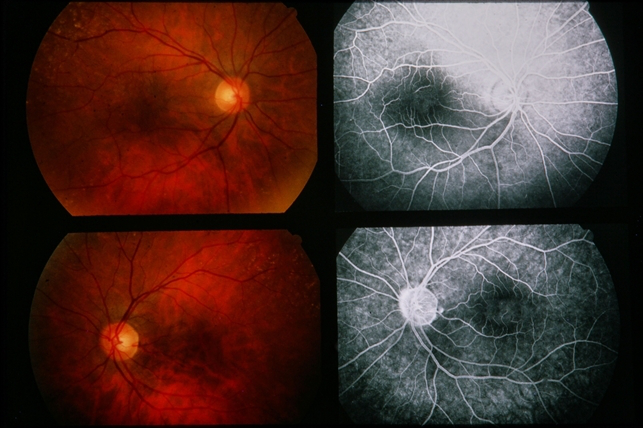

In [45]:
train_id = 165
print('Predicted Caption: {}'.format(predict_captions(train_imgs[train_id], train_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

### Test images tests

In [46]:
test_id = 123
print('Predicted Caption: {}'.format(predict_captions(test_imgs[test_id], test_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: diabetic retinopathy fundus image.
Ground Truth Caption: diabetic retinopathy fundus image.


In [47]:
test_id = 153
print('Predicted Caption: {}'.format(predict_captions(test_imgs[test_id], test_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: 78 year old white female. srnv md. re                                         
Ground Truth Caption: 80-year-old white male. srnv-md re 20/200 le 20/50.


Predicted Caption: 71 year old white female. srnv md. re re le 20/32.
Ground Truth Caption: 59-year-old white male. srnv-md. re 20/100 le 10/200.


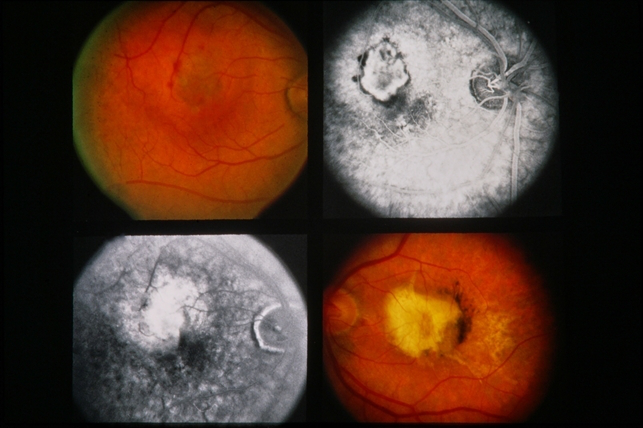

In [48]:
test_id = 39
print('Predicted Caption: {}'.format(predict_captions(test_imgs[test_id], test_imgs_features, final_model)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

# -----------------------------------------------------
# Keywords reinforced

In [37]:
vocab_size = len(word2id_keys)
max_len = max([len(x) for x in cap_toks.values()])
steps_per_epoch = sum([len(cap_toks[img])-1 for img in train_imgs])
embedding_size = 300
key_max_len = max([len(x) for x in keywords_ids.values()])

In [38]:
def data_generator_k(maxlen, imgs_features, imgs, cap_ids, keywords_ids, batch_size = 32):
    
    partial_caps, current_imgs, next_words, count = initialize()
    current_keys = []
    
    while True:
        # For every image data
        for img_path in imgs:
            current_img = imgs_features[img_path]
            current_key = keywords_ids[img_path]
            current_key = sequence.pad_sequences(np.asarray(current_key)[np.newaxis,:], maxlen=key_max_len, padding='post').squeeze(0)
            
            # For every token in single caption data
            for j in range(len(cap_ids[img_path])-1):
                count += 1
                partial_caps.append(cap_ids[img_path][:j+1])
                current_imgs.append(current_img)
                current_keys.append(current_key)
                next_words.append(np.eye(vocab_size)[cap_ids[img_path][j+1]])

                if count >= batch_size:
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    current_imgs = np.asarray(current_imgs)
                    current_keys = np.asarray(current_keys)
                    next_words = np.asarray(next_words)
                    yield ([current_imgs, partial_caps, current_keys], next_words)

                    partial_caps, current_imgs, next_words, count = initialize()
                    current_keys = []

In [39]:
# create keyword model
keyword_model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=key_max_len),
    Lambda(lambda x: K.mean(x, axis=1, keepdims=False)),
    RepeatVector(max_len)
])

In [40]:
x1 = Input(shape=(4096,))
x2 = Input(shape=(max_len,))
x3 = Input(shape=(key_max_len,))

img_input = image_model(x1)
caption_input = caption_model(x2)
keyword_input = keyword_model(x3)

x = Add()([img_input, keyword_input])
x = Add()([x, caption_input])
x = Bidirectional(LSTM(256, return_sequences=False))(x)
out = Dense(vocab_size, activation='softmax')(x)

final_model_k = Model(inputs=[x1, x2, x3], outputs=out)

In [41]:
final_model_k.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model_k.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50, 300)      1229100     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 50, 300)      281400      input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (I

In [54]:
final_model_k.fit_generator(data_generator_k(max_len, train_imgs_features, train_imgs, cap_ids, keywords_ids, batch_size=64), 
                          steps_per_epoch=steps_per_epoch, epochs=1)

Epoch 1/1
16869/16869 [==============================] - 2536s 150ms/step - loss: 0.5446 - acc: 0.8694


In [55]:
final_model_k.save('./checkpoints/model_vgg_new_keywords_e3.h5')

In [44]:
final_model_k = load_model('./checkpoints/model_vgg_new_keywords.h5')

In [46]:
def predict_captions_k(image, images_features, keywords_ids, model):
    start_word = ["<START>"]
    while True:
        par_caps = [word2id[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        current_key = keywords_ids[image]
        current_key = sequence.pad_sequences(np.asarray(current_key)[np.newaxis,:], maxlen=key_max_len, padding='post').squeeze(0)
        e = images_features[image]
        
        preds = model.predict([np.array([e]), np.array(par_caps), np.array([current_key])])
        word_pred = id2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<EOS>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

### Train images tests

Predicted Caption: 67 year old white male. srnv md. re 20/40 le 20/15.
Ground Truth Caption: 67-year-old white male. srnv-md. re 20/40 le 20/15.


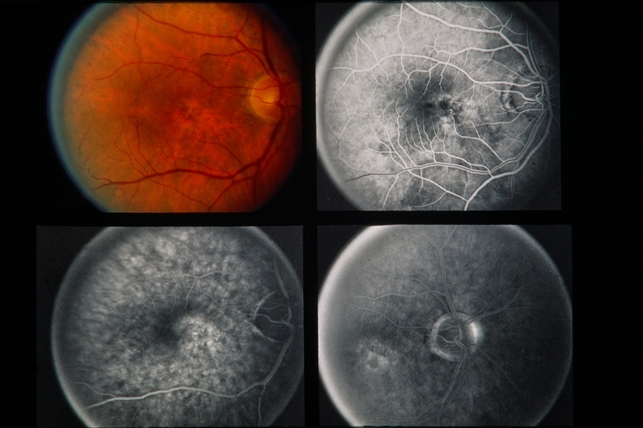

In [66]:
train_id = 211
print('Predicted Caption: {}'.format(predict_captions_k(train_imgs[train_id], train_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

Predicted Caption: 59 year old white female. srnv md. re 20/160 le 20/25.
Ground Truth Caption: 59-year-old white female. srnv-md. re 20/160 le 20/25.


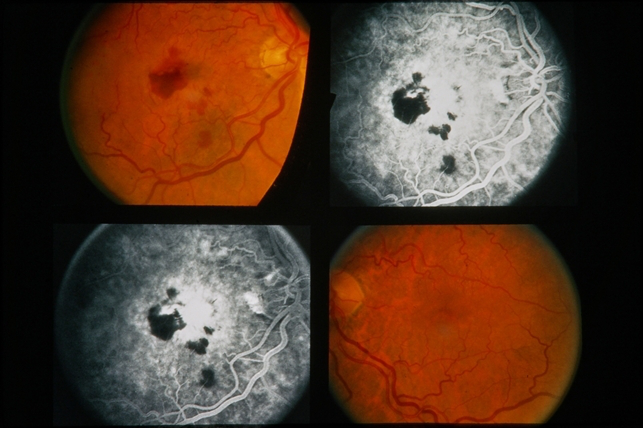

In [59]:
train_id = 324
print('Predicted Caption: {}'.format(predict_captions_k(train_imgs[train_id], train_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

Predicted Caption: 63 year old white female. re 20/30 le 20/32. drusen.
Ground Truth Caption: 63-year-old white female. re 20/50 le 20/32. drusen.


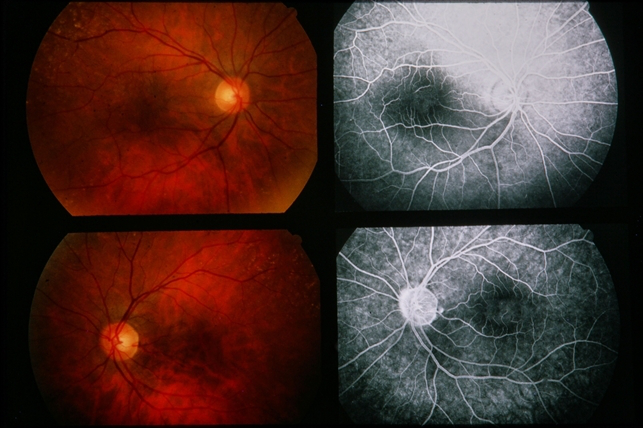

In [60]:
train_id = 165
print('Predicted Caption: {}'.format(predict_captions_k(train_imgs[train_id], train_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[train_imgs[train_id]]))
Image.open(train_imgs[train_id]+'.jpg')

### Test images tests

Predicted Caption: diabetic retinopathy fundus image.
Ground Truth Caption: diabetic retinopathy fundus image.


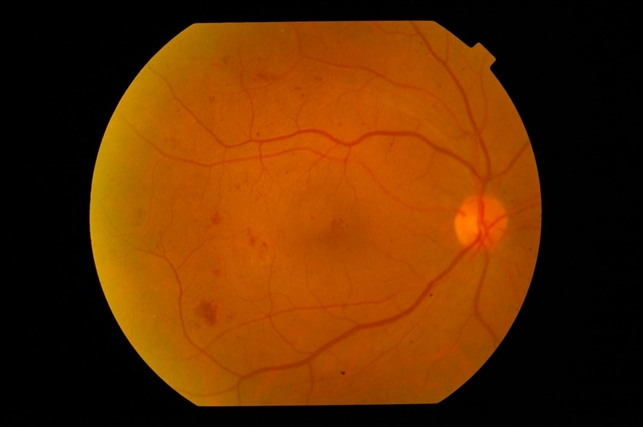

In [61]:
test_id = 123
print('Predicted Caption: {}'.format(predict_captions_k(test_imgs[test_id], test_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: 72 year old white female. srnv md. re cuticular le pseudo best's md.
Ground Truth Caption: 80-year-old white male. srnv-md re 20/200 le 20/50.


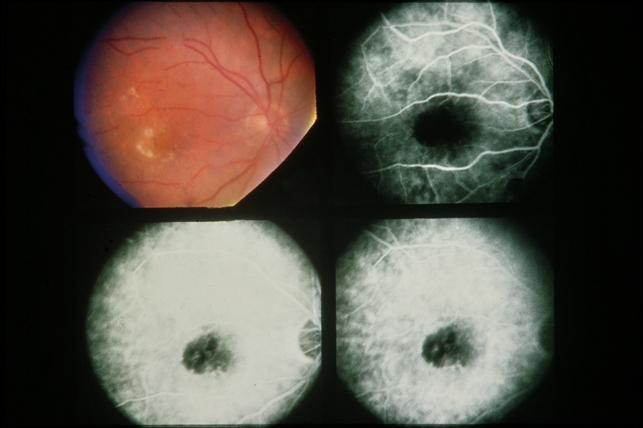

In [62]:
test_id = 153
print('Predicted Caption: {}'.format(predict_captions_k(test_imgs[test_id], test_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: 66 year old white female. srnv md. re 20/200 le male. re 10/200 le 20/250.
Ground Truth Caption: 59-year-old white male. srnv-md. re 20/100 le 10/200.


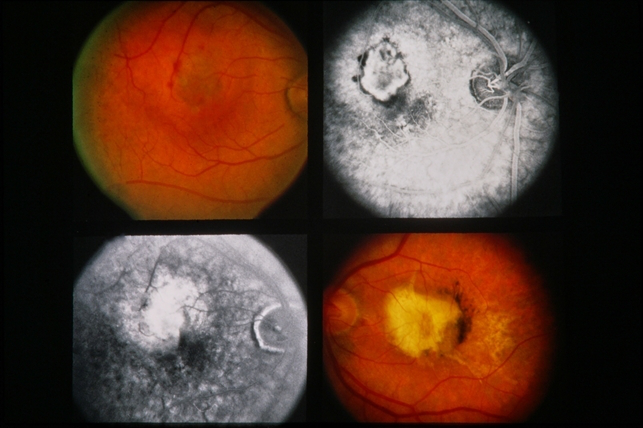

In [63]:
test_id = 39
print('Predicted Caption: {}'.format(predict_captions_k(test_imgs[test_id], test_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: 70 year old white male. srnv md. re 20/80 le 20/64.
Ground Truth Caption: 80-year-old white male. srnv-md. re 20/200 le 20/50.


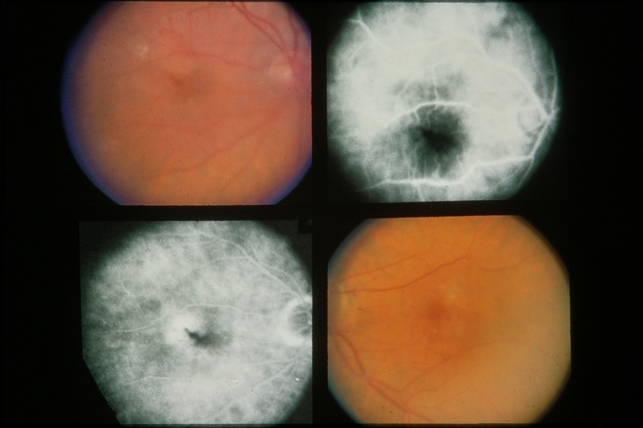

In [64]:
test_id = 164
print('Predicted Caption: {}'.format(predict_captions_k(test_imgs[test_id], test_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

In [65]:
test_id = 165
print('Predicted Caption: {}'.format(predict_captions_k(test_imgs[test_id], test_imgs_features, keywords_ids, final_model_k)))
print('Ground Truth Caption: {}'.format(descriptions[test_imgs[test_id]]))
Image.open(test_imgs[test_id]+'.jpg')

Predicted Caption: srnv md. 20/70.
Ground Truth Caption: srnv-md
